In [1]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install -q -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 18.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=44f88949541989b790e6faf44cb285b8b0dc85d33d2ff3cce2e5e598b4efc38f
 

In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from official.nlp import optimization
import os
import pandas as pd

In [3]:
dataset = pd.read_csv("/content/dataset_tf.csv")
dataset = dataset.drop('type', axis=1)
# Cetak dataset pelatihan
print("List Dataset:")
print(dataset)

List Dataset:
    label                                                 TF
0       T  Dalam menyelesaikan masalah, saya lebih suka m...
1       T  Saya juga cenderung memperhatikan detail dan m...
2       T  Saya cenderung berpikir secara logis dalam men...
3       T  Saya senang mengamati dan memperhatikan detail...
4       T  aya lebih cenderung membuat keputusan berdasar...
..    ...                                                ...
315     T  Dalam merancang menu dan mengelola dapur, saya...
316     T  Saya mencari solusi yang tidak rumit untuk mas...
317     T              Tidak suka jika tidak berpikir logis.
318     T  Saya paling tidak suka jika tidak berpikir log...
319     T  Tidak suka jika tidak mengambil kendali situas...

[320 rows x 2 columns]


In [4]:
df = pd.DataFrame(dataset)
df['TF'] = df['TF'].str.strip()

# Membagi dataset berdasarkan kelompok
grouped = df.groupby('label')

# Inisialisasi DataFrame train dan valid
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

# Memproses setiap kelompok
for name, group in grouped:
    # Menentukan jumlah data untuk validasi
    valid_size = int(len(group) * 0.2)

    # Memilih data untuk validasi
    valid_data = group.sample(n=valid_size, random_state=42)

    # Memilih data untuk train
    train_data = group.drop(valid_data.index)

    # Menggabungkan hasil pemisahan ke dalam DataFrame train dan valid
    df_train = pd.concat([df_train, train_data])
    df_valid = pd.concat([df_valid, valid_data])

#acak
df_train = df_train.sample(frac=1, random_state=42)
df_valid= df_valid.sample(frac=1, random_state=42)

# Cetak hasil
print("Data Train:")
print(df_train)
print("\nData Valid:")
print(df_valid)

Data Train:
    label                                                 TF
245     T  Gue lebih enjoy ketika ada aksi dan hal-hal ya...
16      F  Suka membantu orang dan ingin membuat mereka n...
189     F  Kepekaan emosi saya membuat saya tidak kurang ...
196     T  Dalam membuat keputusan, saya tidak bisa jika ...
298     F  Saya cenderung peka terhadap perasaan orang-or...
..    ...                                                ...
263     F  Saya suka membuat keputusan berdasarkan kata h...
50      F  Kepribadian feeling (F) saya tercermin dalam s...
227     F  Perasaan saya terhadap orang-orang di sekitar ...
124     T  Jika dihadapkan pada teka-teki yang kompleks d...
257     F  Ketika ada masalah, saya lebih suka mengandalk...

[256 rows x 2 columns]

Data Valid:
    label                                                 TF
155     T  Saya berpikir dengan menggunakan fakta yang ad...
197     T  Yang pasti sih, gua tuh cenderung lebih ga suk...
215     F  Gue gak suka kalau gak bi

In [25]:
train_data = df_train
valid_data = df_valid
target_label = 'F' #label 1 Feeling
label_train = (train_data['label'].str[0] == target_label).astype(int).to_numpy()
label_valid = (valid_data['label'].str[0] == target_label).astype(int).to_numpy()

In [14]:
x_train = train_data['TF'].to_numpy() #isi sesuai kolom dataset
x_valid = valid_data['TF'].to_numpy()
print(x_train.shape,x_valid.shape)
print(label_train)
print(x_train)

(256,) (64,)
[0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1
 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0
 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0
 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1]
['Gue lebih enjoy ketika ada aksi dan hal-hal yang bisa diliat langsung, suka main di luar, cari sensasi, dan nggak terlalu mikirin detail berlebihan. Jadi, kalau ada masalah, gue cenderung cari solusi yang efektif dan cepat tanpa banyak berpikir panjang'
 'Suka membantu orang dan ingin membuat mereka nyaman, fokus pada nilai-nilai yang dianggap penting dalam menjaga kedamaian dan keseimbangan'
 'Kepekaan emosi saya membuat saya tidak kurang terhubung dengan oran

In [15]:
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4'
preprocess_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3"
embedding_model1 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model2 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model3 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model4 = hub.KerasLayer(encoder_url, trainable=True)
preprocess_model1 = hub.KerasLayer(preprocess_url)
# preprocess_model2 = hub.KerasLayer(preprocess_url)
# preprocess_model3 = hub.KerasLayer(preprocess_url)
# preprocess_model4 = hub.KerasLayer(preprocess_url)

In [16]:
def build_classifier_model():
    text_input1 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text1')
#     text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')
#     text_input3 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text3')
#     text_input4 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text4')

    # Gunakan lapisan pre-processing terpisah untuk setiap input
    preprocessing_layer1 = hub.KerasLayer(preprocess_model1, name='preprocessing1')
#     preprocessing_layer2 = hub.KerasLayer(preprocess_model1, name='preprocessing2')
#     preprocessing_layer3 = hub.KerasLayer(preprocess_model1, name='preprocessing3')
#     preprocessing_layer4 = hub.KerasLayer(preprocess_model1, name='preprocessing4')

    encoder_inputs1 = preprocessing_layer1(text_input1)
#     encoder_inputs2 = preprocessing_layer2(text_input2)
#     encoder_inputs3 = preprocessing_layer3(text_input3)
#     encoder_inputs4 = preprocessing_layer4(text_input4)

    encoder1 = hub.KerasLayer(embedding_model1, name='BERT_encoder_1', trainable=True)
#     encoder2 = hub.KerasLayer(embedding_model1, name='BERT_encoder_2', trainable=True)
#     encoder3 = hub.KerasLayer(embedding_model1, name='BERT_encoder_3', trainable=True)
#     encoder4 = hub.KerasLayer(embedding_model1, name='BERT_encoder_4', trainable=True)

    outputs1 = encoder1(encoder_inputs1)['pooled_output']
#     outputs2 = encoder2(encoder_inputs2)['pooled_output']
#     outputs3 = encoder3(encoder_inputs3)['pooled_output']
#     outputs4 = encoder4(encoder_inputs4)['pooled_output']

    # Add a Flatten layer to handle varying input lengths
#     outputs1 = tf.keras.layers.Flatten()(outputs1)
#     outputs2 = tf.keras.layers.Flatten()(outputs2)
#     outputs3 = tf.keras.layers.Flatten()(outputs3)
#     outputs4 = tf.keras.layers.Flatten()(outputs4)
    outputs1 = tf.keras.layers.Dropout(0.5 , name="dropout")(outputs1)

    label1 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier1')(outputs1)
#     label2 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier2')(outputs2)
#     label3 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier3')(outputs3)
#     label4 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier4')(outputs4)

#     concatenated_outputs = tf.keras.layers.concatenate([label1, label2, label3, label4], name='output')

    return tf.keras.Model(inputs=[text_input1], outputs=[label1])


In [17]:
model = build_classifier_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text1 (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 preprocessing1 (KerasLayer  {'input_word_ids': (None,    0         ['text1[0][0]']               
 )                           128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

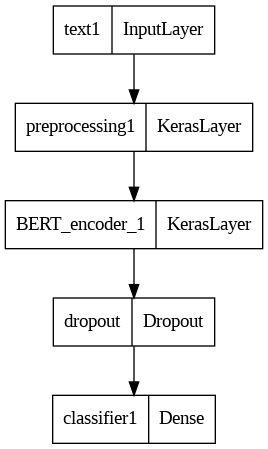

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
epochs = 5
steps_per_epoch = 16
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

In [20]:
!pip install -q tf-models-official

In [21]:
# model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)
# model.load_weights("/content/drive/MyDrive/model_checkpoint_best.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.BinaryCrossentropy(),  # Fungsi kerugian untuk klasifikasi biner
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Path untuk menyimpan checkpoint pada setiap epoch
checkpoint_path_epoch = "/content/drive/MyDrive/model_checkpoint_epoch.h5"

# Path untuk menyimpan checkpoint model terbaik
checkpoint_path_best = "/content/drive/MyDrive/model_checkpoint_best.h5"

# Callback untuk menyimpan checkpoint pada setiap epoch
checkpoint_callback_epoch = ModelCheckpoint(
    filepath=checkpoint_path_epoch,
    save_weights_only=True,
    save_best_only=False,  # Set ke False agar menyimpan pada setiap epoch
    verbose=1
)

# Callback untuk menyimpan checkpoint model terbaik
checkpoint_callback_best = ModelCheckpoint(
    filepath=checkpoint_path_best,
    save_weights_only=True,
    save_best_only=True,  # Set ke True agar hanya menyimpan model terbaik
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [23]:
# untuk lanjut
model.fit(
    x=x_train, y=label_train,
    epochs=20,
    validation_data=(x_valid, label_valid),batch_size=batch_size,
)

Epoch 1/20
128/128 [==============================] - 83s 239ms/step - loss: 0.7054 - accuracy: 0.5547 - val_loss: 0.6754 - val_accuracy: 0.5781
Epoch 2/20
128/128 [==============================] - 17s 136ms/step - loss: 0.6874 - accuracy: 0.5664 - val_loss: 0.6542 - val_accuracy: 0.6562
Epoch 3/20
128/128 [==============================] - 14s 110ms/step - loss: 0.6530 - accuracy: 0.6250 - val_loss: 0.6135 - val_accuracy: 0.7344
Epoch 4/20
128/128 [==============================] - 15s 114ms/step - loss: 0.5780 - accuracy: 0.7617 - val_loss: 0.5113 - val_accuracy: 0.7969
Epoch 5/20
128/128 [==============================] - 13s 102ms/step - loss: 0.4806 - accuracy: 0.8281 - val_loss: 0.4113 - val_accuracy: 0.8438
Epoch 6/20
128/128 [==============================] - 14s 109ms/step - loss: 0.3585 - accuracy: 0.8711 - val_loss: 0.3360 - val_accuracy: 0.8594
Epoch 7/20
128/128 [==============================] - 14s 108ms/step - loss: 0.3114 - accuracy: 0.8984 - val_loss: 0.2791 - val_ac

In [ ]:
model.predict(["saya suka berpikir kreatif dan liar"])

In [24]:
# Mendapatkan daftar perangkat yang tersedia (CPU dan GPU)
devices = tf.config.list_physical_devices()

if len(devices) == 0:
    print("Tidak ada perangkat fisik yang ditemukan.")
else:
    print("Perangkat yang tersedia:")
    for device in devices:
        print(f"- {device.name} ({device.device_type})")

Perangkat yang tersedia:
- /physical_device:CPU:0 (CPU)
- /physical_device:GPU:0 (GPU)


In [26]:
print(model.predict(["Penuh dengan kepekaan, selalu memperhatikan emosi orang lain, dan mampu merasakan suasana hati dengan sangat dalam."])) #Feeling

1/1 [==============================] - 1s 1s/step
[[0.9980496]]


In [27]:
print(model.predict(["Cenderung menggunakan logika dan analisis mendalam dalam setiap keputusan yang diambil, mempertimbangkan fakta-fakta sebelum bertindak"])) #Thinking

1/1 [==============================] - 0s 44ms/step
[[0.00232888]]
